<a href="https://colab.research.google.com/github/Maxmuleiv/Proyecto-Industrial/blob/master/AnalisisPobrezaMultidimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación Packages

In [0]:
%reset-f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx
from scipy.stats import pointbiserialr

# Importación BD

In [0]:
#url1="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/pobreza5d.csv?raw=true" #url base datos 
#url11="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/carencias.csv?raw=true"
#datos5D = pd.read_csv(url11,";") #importación base datos pobres 5d

In [0]:
#url2="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/dimensiones5D.csv?raw=true" #url base datos 
#url22="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/dimensiones.csv?raw=true"
#dimensiones = pd.read_csv(url22,";") #importación base datos por dimension

In [141]:
url3="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/CASENtipologias.csv?raw=true" #url base datos 
casen = pd.read_csv(url3,";", encoding='iso-8859-1') #importación base datos para calculo tipo hogares y tipologias de las carencias
casen.head()

,folio,o,id_vivienda,hogar,zona,tot_hog,tot_per,tot_par,tot_nuc,pco1,nucleo,pco2,yautcor,ytotcor,yautcorh,ymonecorh,ytotcorh,yoprcor,yoprcorh,ytrabajocor,ytrabajocorh,ypchautcor,ypc,ypchtrabajo,pobreza,qaut,qautr,numper,Allegamiento externo,Allegamiento interno,Hacinamiento,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,Pobreza 5D
0,110110020301,1,1101100203,1,Urbano,1,1,0,1,1,1,1,200000.0,211091.0,200000,211091,211091,200000.0,200000.0,200000.0,200000,200000,211091,200000,No pobres,III,III,1,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,Pobre
1,110110020601,1,1101100206,1,Urbano,1,2,0,1,1,1,1,130000.0,130000.0,463333,463333,463333,50000.0,50000.0,130000.0,130000,231667,231667,65000,No pobres,III,III,2,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,Pobre
2,110110020601,2,1101100206,1,Urbano,1,2,0,1,5,1,5,333333.0,333333.0,463333,463333,463333,NaN,NaN,NaN,130000,231667,231667,65000,No pobres,III,III,2,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,Pobre
3,110110030401,1,1101100304,1,Urbano,1,1,0,1,1,1,1,200000.0,200000.0,200000,200000,200000,200000.0,200000.0,200000.0,200000,200000,200000,200000,No pobres,III,III,1,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,Pobre
4,110110040201,1,1101100402,1,Urbano,1,1,0,1,1,1,1,442550.0,447482.0,442550,447482,447482,250000.0,250000.0,333333.0,333333,442550,447482,333333,No pobres,V,V,1,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,Pobre


# Categorizacion por tipo de familia

In [142]:
casen2=np.array(casen);#print(casen2)
hogares_unicos,hogares_index,hogares_inv,hogares_count=np.unique(casen2[:,0],return_index=True, return_inverse=True, return_counts=True)
n_hogares=len(hogares_unicos)
n_personas=len(casen2[:,0])
cols=np.array(casen[["pco1","numper","tot_nuc"]])

dd=np.zeros((n_hogares,1))
ddd=np.zeros((n_personas,1))
for i,h in enumerate(hogares_unicos):
  #print(h,i)
  miembros=np.where(casen2[:,0]==h)[0]#;print(miembros)
  #n_miembros=len(miembros)
  m_cols=cols[miembros]
  a=0
  if 2 in m_cols[:,0] or 3 in m_cols[:,0]:
    a=1;#print(h,"tiene pareja")
  b=m_cols[0,1]
  c=m_cols[0,2]
  #print(a,b,c)
  if b==1: #hogar unipersonal
    d=1
  elif b==c:
    d=6 #hogar censal   
  elif b>1 and a==0 and c==1:
    d=2 #hogar monoparental nuclear
  elif b>1 and a==1 and c==1:
    d=3 #hogar biparental nuclear
  elif b>1 and a==0 and c>1:
    d=4 #hogar monoparental extendido
  elif b>1 and a==1 and c>1:
    d=5 #hogar biparental extendido
  
  dd[i]=d
  ddd[miembros]=d
# dd es un arreglo por hogar único que indica que tipo de hogar es
# ddd es el tipo de hogar al que pertenecen los miembros
casen["d"]=ddd.astype(int)
#casen.head()
casen[casen.d == 6].head()

,folio,o,id_vivienda,hogar,zona,tot_hog,tot_per,tot_par,tot_nuc,pco1,nucleo,pco2,yautcor,ytotcor,yautcorh,ymonecorh,ytotcorh,yoprcor,yoprcorh,ytrabajocor,ytrabajocorh,ypchautcor,ypc,ypchtrabajo,pobreza,qaut,qautr,numper,Allegamiento externo,Allegamiento interno,Hacinamiento,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,Pobreza 5D,d
470,110111291101,1,1101112911,1,Urbano,1,2,0,2,1,1,1,150000.0,150000.0,420000,420000,420000,NaN,NaN,150000.0,420000,210000,210000,210000,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,Hacinamiento crítico (5 y más),0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,Pobre,6
471,110111291101,2,1101112911,1,Urbano,1,2,0,2,11,2,1,270000.0,270000.0,420000,420000,420000,270000.0,270000.0,270000.0,420000,210000,210000,210000,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,Hacinamiento crítico (5 y más),0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,Pobre,6
556,110111561001,1,1101115610,1,Urbano,1,2,0,2,1,1,1,195000.0,205000.0,395000,405000,405000,195000.0,195000.0,195000.0,395000,197500,202500,197500,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,Pobre,6
557,110111561001,2,1101115610,1,Urbano,1,2,0,2,5,2,1,200000.0,200000.0,395000,405000,405000,NaN,NaN,200000.0,395000,197500,202500,197500,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,Pobre,6
717,110111990601,1,1101119906,1,Urbano,1,2,0,2,1,1,1,240000.0,240000.0,240000,240000,240000,240000.0,240000.0,240000.0,240000,120000,120000,120000,Pobres no extremos,II,II,2,Sin allegamiento externo,Con allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,Pobre,6


# Definicion funciones

In [0]:
# FUNCION PARA OBTENCION HEATMAPS POR TIPO DE CORRELACION (PEARSON, KENDALL Y SPEARMAN)
def creacion_heatmap(Nombre_metodo,Tabla_variables,Negativos,Comentario_grafico):
  

  if  Negativos==False:
    color_min=-0.01
  else:
    color_min=-0.5
    
  Tabla_correlaciones = Tabla_variables.corr(method=Nombre_metodo)
  plt.figure(figsize = (20,10)) #arreglar el tamaño del gráfico

  mask = np.zeros(Tabla_correlaciones.shape, dtype=bool) #eliminacion datos simetricos
  mask[np.triu_indices(len(mask))] = True

  mapa=sb.heatmap(Tabla_correlaciones.values.round(2), xticklabels=Tabla_correlaciones.columns, # heatmap pearson
            yticklabels=Tabla_correlaciones.columns,vmin =color_min, vmax = 0.5, center = 0, cmap = "RdBu",annot=True, mask=mask, linewidths=3)


#antes fije vmax en 0.12 por si lo quiero volver a poner
  b, t = mapa.get_ylim() # identificar limites de corte
  mapa.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".png",bbox_inches="tight")
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".svg",bbox_inches="tight")

  return
  plt.show()

# Cálculo correlaciones carencias 5D

In [144]:
datos5D=casen[["folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
datos5D=datos5D.drop_duplicates()
datos5D = datos5D.drop(['folio'],axis=1)
pearson5d = datos5D.corr(method='pearson')
pearson5d

,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
Asistencia,1.000000,0.001807,-0.001669,0.057216,-0.035233,-0.033008,-0.000002,-0.023322,-0.093290,-0.013697,-0.072353,-0.075101,0.021848,0.014863,0.028150
Rezago escolar,0.001807,1.000000,0.011478,-0.003866,-0.053011,-0.027417,-0.015600,-0.009737,-0.096590,-0.015257,-0.081555,-0.065003,0.005373,0.012865,0.026042
Escolaridad,-0.001669,0.011478,1.000000,-0.095546,-0.185647,-0.170200,-0.148758,-0.077000,-0.025015,-0.101716,0.043571,-0.062650,-0.001392,-0.063631,-0.047749
Malnutricion infantil,0.057216,-0.003866,-0.095546,1.000000,-0.078169,-0.035771,-0.028609,-0.023408,-0.120435,0.029542,-0.098659,-0.088984,-0.014239,0.012719,0.020964
Sistema de salud,-0.035233,-0.053011,-0.185647,-0.078169,1.000000,0.008826,0.044807,0.077482,-0.060174,-0.122584,-0.147175,-0.101106,0.030433,0.012730,-0.001617
Atencion,-0.033008,-0.027417,-0.170200,-0.035771,0.008826,1.000000,0.016871,-0.048991,0.020231,-0.077401,-0.108774,-0.031949,-0.001215,0.048181,0.026240
Ocupacion,-0.000002,-0.015600,-0.148758,-0.028609,0.044807,0.016871,1.000000,-0.161202,-0.077768,-0.066781,-0.182155,-0.058520,0.006246,0.033398,0.039229
Seguridad social,-0.023322,-0.009737,-0.077000,-0.023408,0.077482,-0.048991,-0.161202,1.000000,-0.054330,-0.101963,-0.133876,-0.367012,-0.015733,-0.000908,0.020760
Jubilaciones,-0.093290,-0.096590,-0.025015,-0.120435,-0.060174,0.020231,-0.077768,-0.054330,1.000000,-0.192563,-0.164503,-0.057774,-0.017453,-0.045674,-0.026736
Habitabilidad,-0.013697,-0.015257,-0.101716,0.029542,-0.122584,-0.077401,-0.066781,-0.101963,-0.192563,1.000000,-0.050858,-0.089167,0.039900,0.070012,0.062424


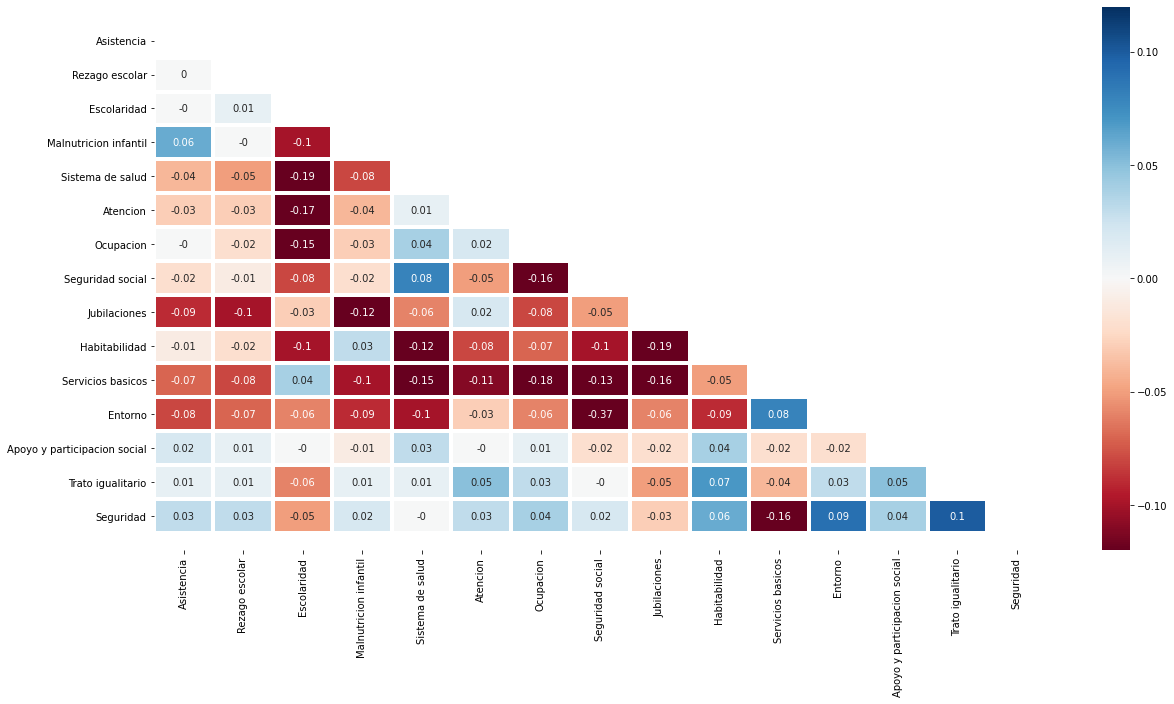

In [145]:
creacion_heatmap("pearson",datos5D,True,"Correlaciones")


In [0]:
# importacion datos correlaciones excel

pearson5d.to_excel(excel_writer = "pearson5d.xlsx")


# Cálculo correlaciones por tipo de hogar


total de hogares = 44972
total de hogares = 44972
total de h. unipersonal = 1246 - 2.77 %
total de h. monoparental nuclear = 6301 - 14.01 %
total de h. biparental nuclear = 19933 - 44.32 %
total de h. monoparental extendido = 6173 - 13.73 %
total de h. biparental extendido = 11142 - 24.78 %
total de h. censal = 177 - 0.39 %


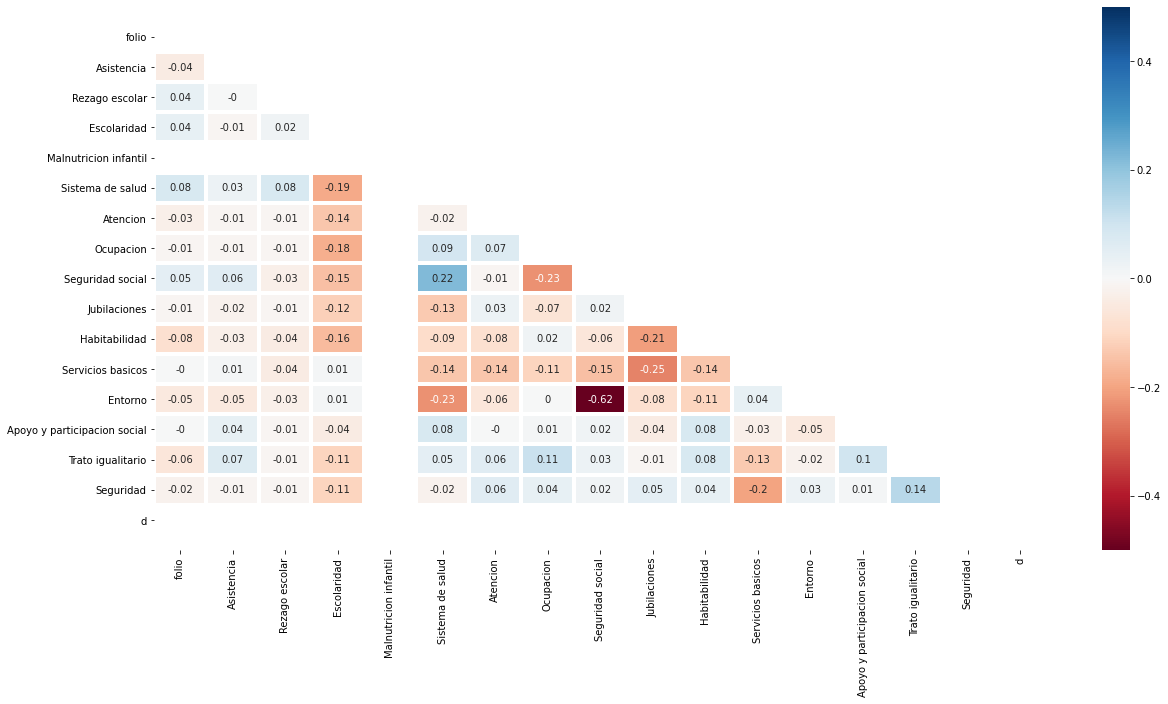

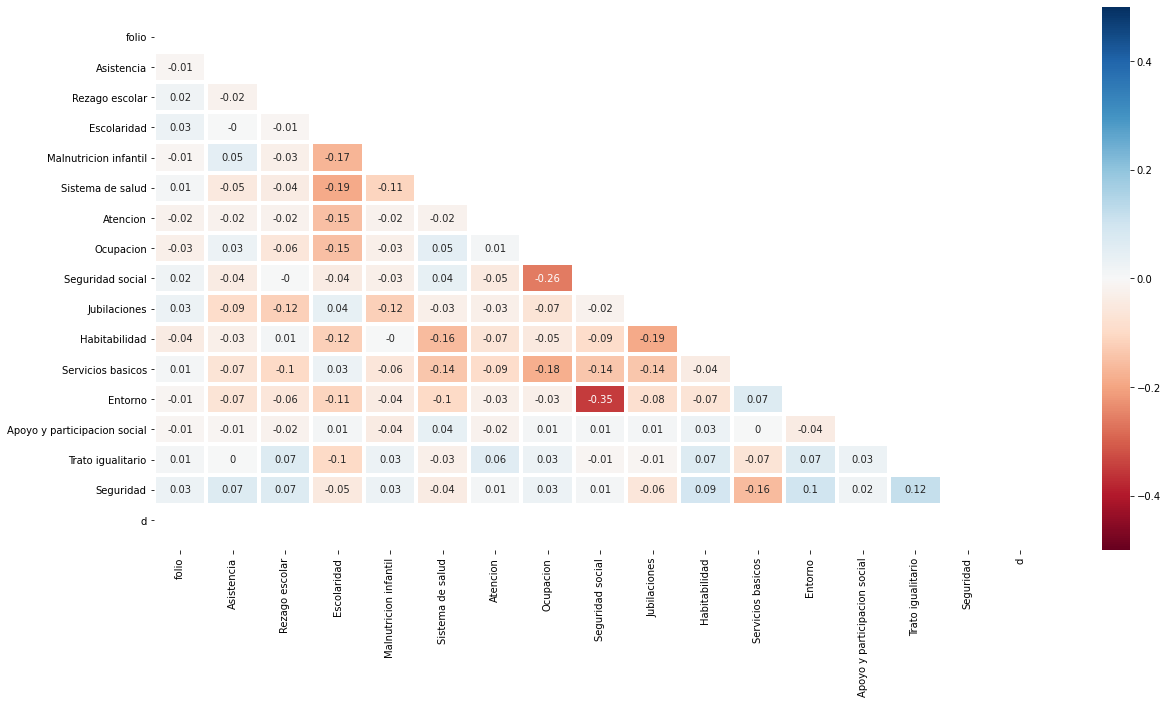

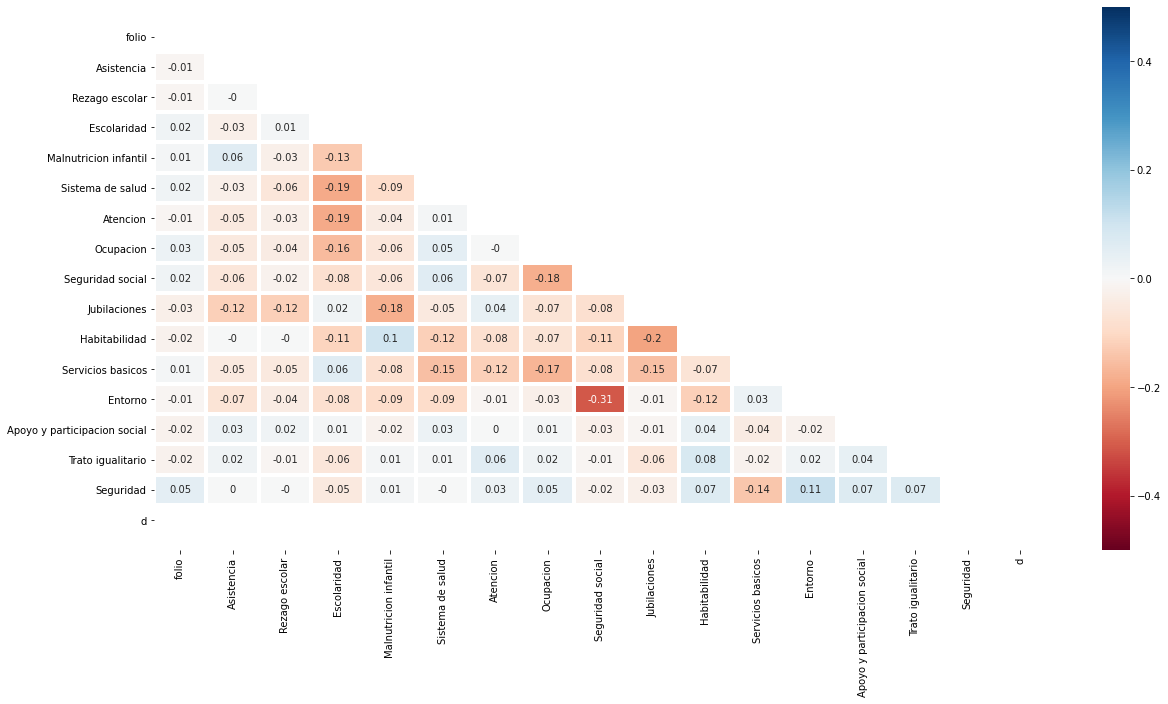

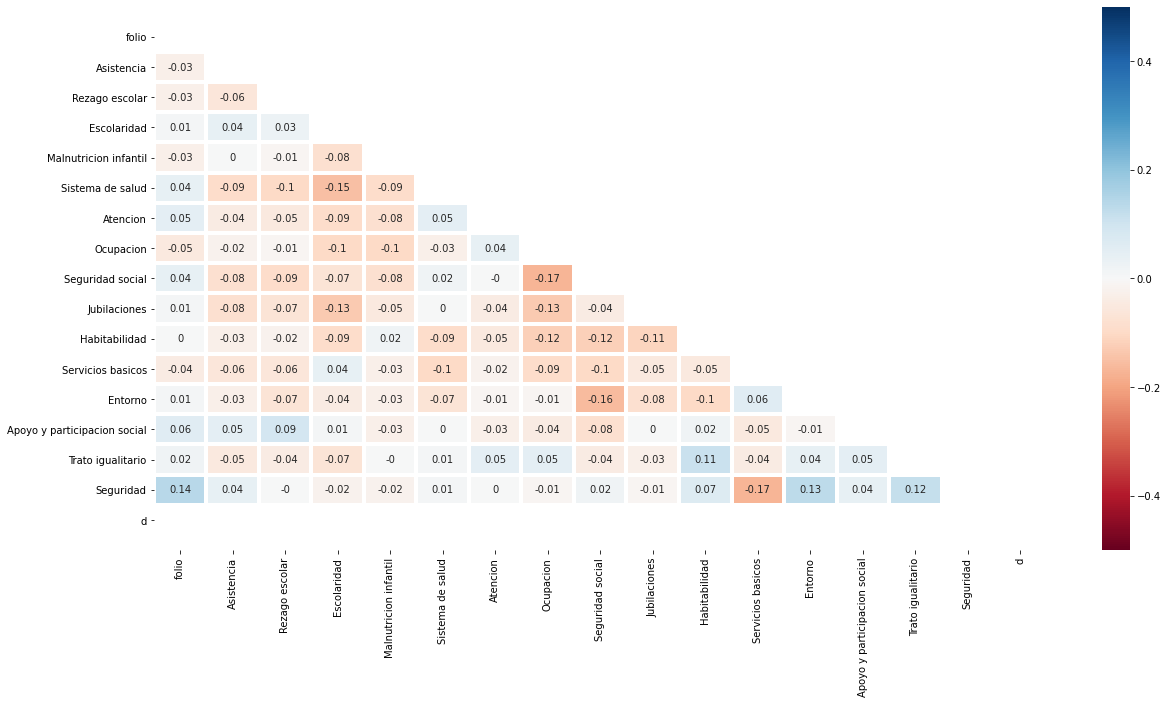

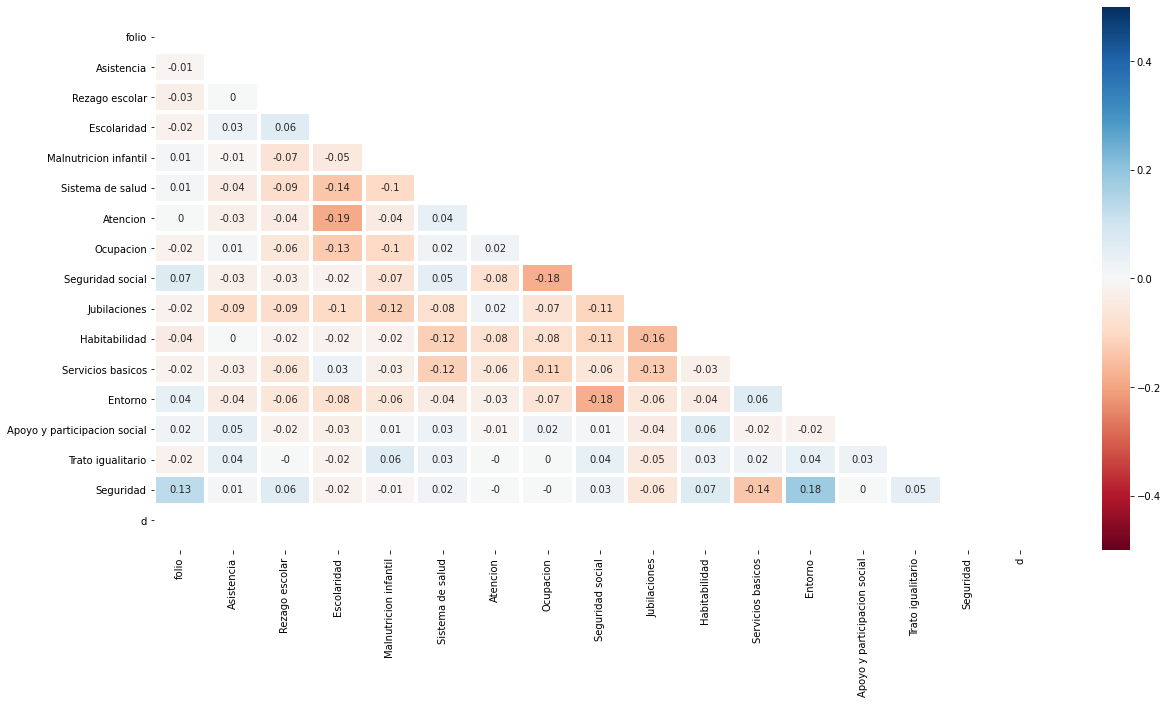

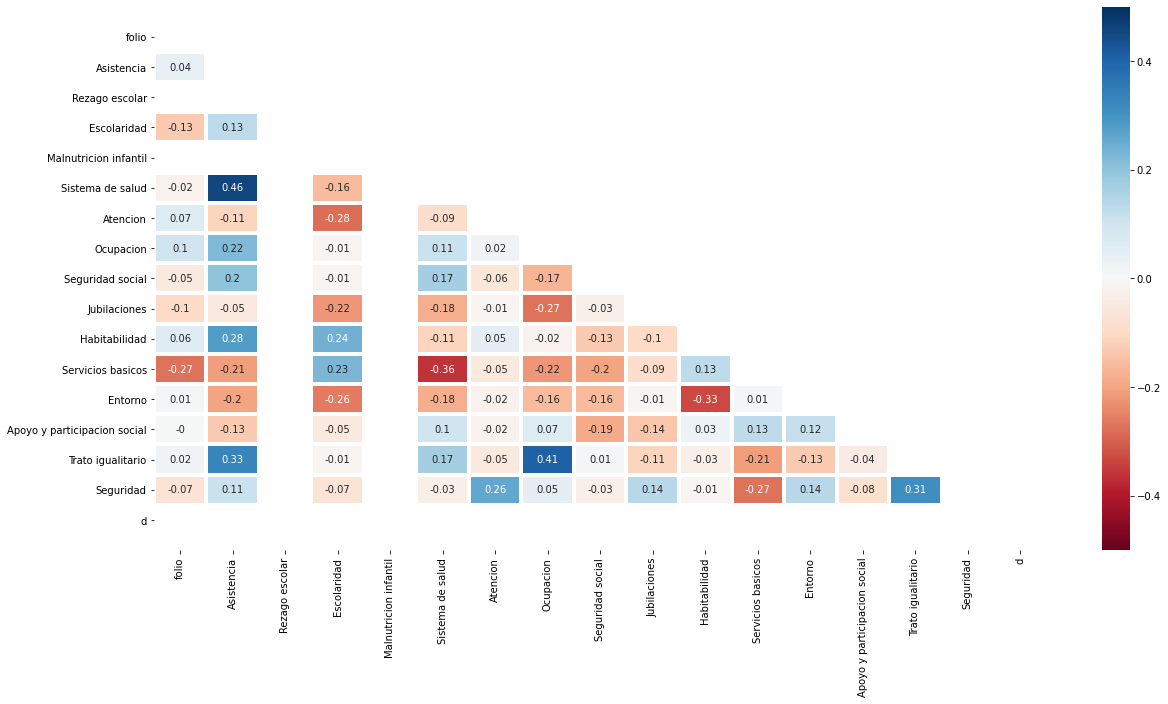

In [176]:
tipohogares=casen[["folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad","d"]]
tipohogares.head()


t_hogares=len(tipohogares.index)
print("total de hogares =",t_hogares)
hogar_unip=tipohogares[tipohogares.d == 1]
hogar_mononuc=tipohogares[tipohogares.d == 2]
hogar_binuc=tipohogares[tipohogares.d == 3]
hogar_monoex=tipohogares[tipohogares.d == 4]
hogar_biex=tipohogares[tipohogares.d == 5]
hogar_cen=tipohogares[tipohogares.d == 6]

t_unip=len(hogar_unip.index)
t_mononuc=len(hogar_mononuc.index)
t_binuc=len(hogar_binuc.index)
t_monoex=len(hogar_monoex.index)
t_biex=len(hogar_biex.index)
t_cen=len(hogar_cen.index)





print("total de hogares =",total_hogares)
print("total de h. unipersonal =",t_unip, "-",round(t_unip*100/total_hogares,2),"%")
print("total de h. monoparental nuclear =",t_mononuc,"-",round(t_mononuc*100/total_hogares,2),"%")
print("total de h. biparental nuclear =",t_binuc,"-",round(t_binuc*100/total_hogares,2),"%")
print("total de h. monoparental extendido =",t_monoex,"-",round(t_monoex*100/total_hogares,2),"%")
print("total de h. biparental extendido =",t_biex,"-",round(t_biex*100/total_hogares,2),"%")
print("total de h. censal =",t_cen,"-",round(t_cen*100/total_hogares,2),"%")


creacion_heatmap("pearson",hogar_unip,True,"Correlaciones")
creacion_heatmap("pearson",hogar_mononuc,True,"Correlaciones")
creacion_heatmap("pearson",hogar_binuc,True,"Correlaciones")
creacion_heatmap("pearson",hogar_monoex,True,"Correlaciones")
creacion_heatmap("pearson",hogar_biex,True,"Correlaciones")
creacion_heatmap("pearson",hogar_cen,True,"Correlaciones")


# Cálculo correlaciones por dimensiones agrupadas (5D)


In [148]:
# Calculo de indicador por dimension

dim=datos5D
dim["Educacion"]=np.nan
dim["Salud"]=np.nan
dim["Trabajo y seguridad social"]=np.nan
dim["Vivienda y entorno"]=np.nan
dim["Redes y cohesion social"]=np.nan

for p in dim.index:
 # dim[p,"Educacion"]=dim[p,"Asistencia"]
  
  dim['Educacion'][p]=dim['Asistencia'][p]+dim['Rezago escolar'][p]+dim['Escolaridad'][p]
  dim['Salud'][p]=dim['Malnutricion infantil'][p]+dim['Sistema de salud'][p]+dim['Atencion'][p]
  dim['Trabajo y seguridad social'][p]=dim['Ocupacion'][p]+dim['Seguridad social'][p]+dim['Jubilaciones'][p]
  dim['Vivienda y entorno'][p]=dim['Habitabilidad'][p]+dim['Servicios basicos'][p]+dim['Entorno'][p]
  dim['Redes y cohesion social'][p]=dim['Apoyo y participacion social'][p]+dim['Trato igualitario'][p]+dim['Seguridad'][p]
  dim["Educacion"][p]=int(dim["Educacion"][p])
#dim[dim.Educacion == 3]
dim=dim[["Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]]
dim

#datos5D=casen[["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_l

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
0,1.0,1.0,1.0,1.0,0.0
1,1.0,0.0,3.0,2.0,2.0
3,0.0,0.0,1.0,3.0,2.0
4,0.0,0.0,1.0,2.0,2.0
5,0.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...
44963,1.0,0.0,2.0,2.0,0.0
44965,0.0,0.0,1.0,2.0,0.0
44967,1.0,0.0,0.0,3.0,0.0
44968,1.0,0.0,1.0,1.0,0.0


In [149]:
pearsonDim = dim.corr(method='pearson')
pearsonDim

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
Educacion,1.000000,-0.232382,-0.189302,-0.139436,-0.024152
Salud,-0.232382,1.000000,-0.042665,-0.268346,0.043461
Trabajo y seguridad social,-0.189302,-0.042665,1.000000,-0.507549,-0.003020
Vivienda y entorno,-0.139436,-0.268346,-0.507549,1.000000,0.018705
Redes y cohesion social,-0.024152,0.043461,-0.003020,0.018705,1.000000


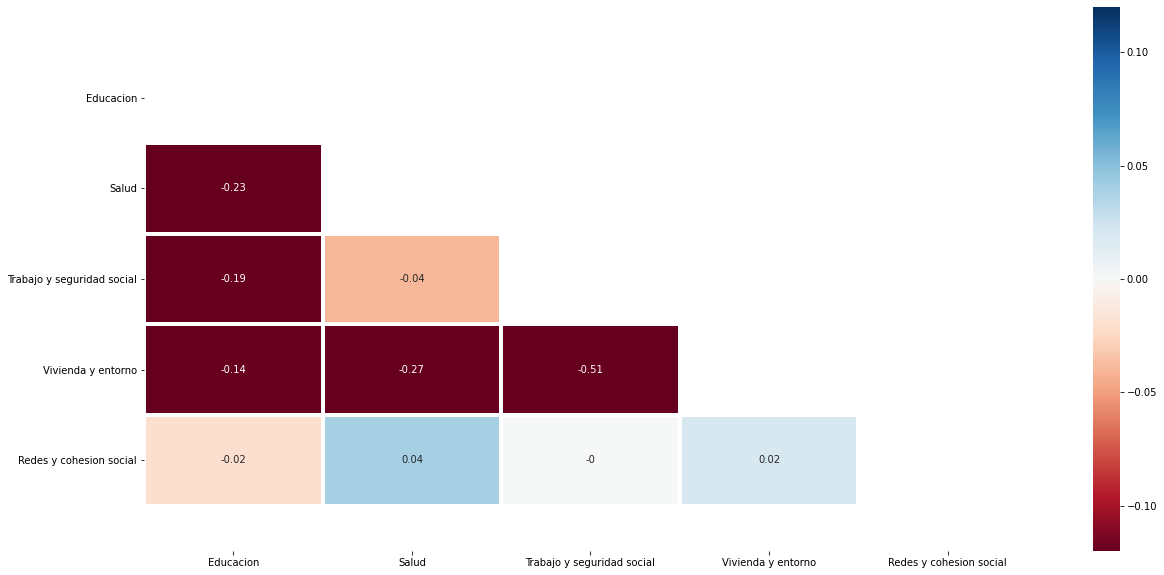

In [150]:
# OBTENCION HEATMAPS PEARSON, KENDALL Y SPEARMAN POR DIMENSIONES

creacion_heatmap("pearson",dim,True,"DIM")


In [0]:
# exportacion datos correlaciones excel

pearsonDim.to_excel(excel_writer = "pearsonDim.xlsx")
dim.to_excel(excel_writer="hola.xlsx")


# Análisis red carencias

In [152]:
#transformación datos insice matriz de correlaciones, en este caso se usa pearson
indices = pearson5d.index.values
# transformación datos carencias a matriz, se emplea en este caso pearson
matrizCarencias = np.asmatrix(pearson5d)
#Creación de grafo con datos de la matriz de correlaciones Matriz5d
Gcarencias = nx.from_numpy_matrix(matrizCarencias)

#etiquetado de nosos para que coincidan con nombres de carencias
Gcarencias = nx.relabel_nodes(Gcarencias,lambda x: matrizCarencias[x,x]) # revisar aca, redefinicion de las etiquetas

#Muestra los arcos con sus respectivos pesos
Gcarencias.edges(data=True)

EdgeDataView([(1.0, 1.0, {'weight': 1.0})])

In [0]:
#Funcion para crear redes en base a correlaciones

def create_corr_network_1(G):
    #creacion lista de arcos y lista de pesos
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #Layout circular del grafo
    positions=nx.circular_layout(G)
    
    #Tamaño de la figura
    plt.figure(figsize=(15,15))

    #Ploteo de nodos
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    
    #Estilo etiquetas
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #Ploteo de arcos
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid')
    
    # Presentar el gráfico sin eje
    plt.axis('off')
   
    # Importación imagen grafo
    plt.savefig("grafocorr.png", format="PNG")
    plt.savefig("grafocorr.svg", format="SVG")
    plt.show() 
    create_corr_network_1(G)

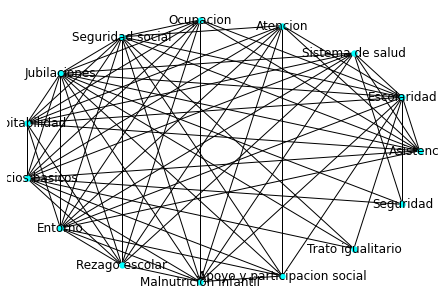

In [154]:
# Transform it in a links data frame (3 columns only):
links = pearson5d.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# eliminar correlaciones autorreferenciadas
links_filtered=links.loc[ (links['value'] < 0) & (links['var1'] != links['var2']) ]
links_filtered
 
# Creación gráfico
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
nx.draw_circular(G, with_labels=True, node_color='cyan', node_size=40, edge_color='black', linewidths=0.01, font_size=12)

#b, t = mapa5d.get_ylim() # identificar limites de corte
#mapa5d.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte

# Cálculo coeficiente de determinación R cuadrado para dimensiones

In [155]:
dim.head()

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
0,1.0,1.0,1.0,1.0,0.0
1,1.0,0.0,3.0,2.0,2.0
3,0.0,0.0,1.0,3.0,2.0
4,0.0,0.0,1.0,2.0,2.0
5,0.0,1.0,0.0,2.0,1.0


In [156]:
dimensiones2=dim.T
dimensiones2.head()

,0,1,3,4,5,8,12,14,16,22,23,31,35,39,43,48,54,57,65,71,74,79,83,85,89,97,99,101,103,108,109,110,113,117,119,122,125,128,140,143,...,44887,44889,44893,44895,44897,44898,44904,44906,44910,44914,44916,44918,44920,44922,44923,44924,44927,44929,44931,44935,44937,44938,44940,44942,44943,44945,44947,44948,44949,44950,44951,44953,44960,44961,44962,44963,44965,44967,44968,44970
Educacion,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
Salud,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Trabajo y seguridad social,1.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0
Vivienda y entorno,1.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,...,1.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
Redes y cohesion social,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# cálculo coef. 
dimensionesR=np.corrcoef(dimensiones2)

In [158]:
pd.DataFrame(dimensionesR).head()

,0,1,2,3,4
0,1.000000,-0.232382,-0.189302,-0.139436,-0.024152
1,-0.232382,1.000000,-0.042665,-0.268346,0.043461
2,-0.189302,-0.042665,1.000000,-0.507549,-0.003020
3,-0.139436,-0.268346,-0.507549,1.000000,0.018705
4,-0.024152,0.043461,-0.003020,0.018705,1.000000


In [0]:
# obtención coef. r cuadrado
dimensionesR2=dimensionesR**2

In [160]:
dimensionesR2=pd.DataFrame(dimensionesR2)
dimensionesR2.head()

,0,1,2,3,4
0,1.000000,0.054001,0.035835,0.019442,0.000583
1,0.054001,1.000000,0.001820,0.072010,0.001889
2,0.035835,0.001820,1.000000,0.257606,0.000009
3,0.019442,0.072010,0.257606,1.000000,0.000350
4,0.000583,0.001889,0.000009,0.000350,1.000000


In [0]:
pd.DataFrame(dimensionesR).to_excel(excel_writer = "r.xlsx")
dimensionesR2.to_excel(excel_writer = "r_cuadrado.xlsx")

In [177]:
dim.cov()

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
Educacion,0.317255,-0.068860,-0.073762,-0.063065,-0.008082
Salud,-0.068860,0.276770,-0.015527,-0.113361,0.013585
Trabajo y seguridad social,-0.073762,-0.015527,0.478564,-0.281940,-0.001241
Vivienda y entorno,-0.063065,-0.113361,-0.281940,0.644788,0.008924
Redes y cohesion social,-0.008082,0.013585,-0.001241,0.008924,0.352995


# Obtención tipologías

